In [2]:
import pandas as pd
import numpy as np
import ujson
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import sys
import ast
import os
import importlib
import re

# Add the parent directory to the system path so the notebook can find the eBird2ABAP package
sys.path.append(os.path.abspath("../"))

from eBird2ABAP import *

# Reload the module to apply changes
import eBird2ABAP

importlib.reload(eBird2ABAP)

<module 'eBird2ABAP' from '/Users/rafnuss/Library/CloudStorage/OneDrive-Vogelwarte/eBird2ABAP/eBird2ABAP/__init__.py'>

Define Africa limits


In [3]:
min_lat = -34.83  # Southernmost point (Cape Agulhas, South Africa)
max_lat = 37.33  # Northernmost point (Ras ben Sakka, Tunisia)
min_lon = -17.31  # Westernmost point (Cap Vert, Senegal)
max_lon = 51.16  # Easternmost point (Ras Hafun, Somalia)

Function to read ABAP data


In [4]:
def load_abap(type=["ad", "fp"]):
    ac_all = []
    ar_all = []
    for t in type:
        ac = pd.read_csv(
            f"../data/ABAP/1_s2_{t}_headers.csv",
            usecols=[
                "card",
                "startdate",
                "enddate",
                "starttime",
                "pentad",
                "observer",
                "totalhours",
                "totalspp",
            ],
            parse_dates=["startdate", "enddate"],
            dayfirst=True,
        )
        ac.drop(["starttime", "enddate"], axis=1, inplace=True)
        ac["lat"], ac["lon"] = pentad2latlng(ac["pentad"])

        # filter for africa
        ac = ac[
            (ac["lat"] >= min_lat)
            & (ac["lat"] <= max_lat)
            & (ac["lon"] >= min_lon)
            & (ac["lon"] <= max_lon)
        ]

        ar = pd.read_csv(
            f"../data/ABAP/1_s2_{t}_records.csv",
            usecols=[
                "card",
                "ADU",
                "SEQ",
            ],
        )
        ar = ar[ar["card"].isin(ac["card"])]

        ac["type"] = t

        ac_all.append(ac)
        ar_all.append(ar)

    ac_all = pd.concat(ac_all, ignore_index=True)
    ar_all = pd.concat(ar_all, ignore_index=True)

    a = pd.merge(ar_all, ac_all, how="left")

    return a, ac_all, ar_all

## All records


In [5]:
a_all, ac_all, ar_all = load_abap()

In [6]:
a_all

,card,ADU,SEQ,startdate,pentad,observer,totalhours,totalspp,lat,lon,type
0,0000_3435a040159a20160525,161,3,2016-05-25,0000_3435,40159.0,1,5,-0.041667,34.625000,ad
1,0000_3435a040159a20191010,161,12,2019-10-10,0000_3435,40159.0,1,13,-0.041667,34.625000,ad
2,0000_3445a040159a20160525,161,14,2016-05-25,0000_3445,40159.0,1,18,-0.041667,34.791667,ad
3,0000_3445a040159a20160530,161,8,2016-05-30,0000_3445,40159.0,2,19,-0.041667,34.791667,ad
4,0000_3445a040159a20180211,161,17,2018-02-11,0000_3445,40159.0,2,17,-0.041667,34.791667,ad
...,...,...,...,...,...,...,...,...,...,...,...
24523750,2400_2900_022427_20240815,521,24,2024-08-15,2400_2900,22427.0,3,26,-24.041667,29.041667,fp
24523751,2400_2900_022427_20240815,4142,25,2024-08-15,2400_2900,22427.0,3,26,-24.041667,29.041667,fp
24523752,2400_2900_022427_20240815,780,26,2024-08-15,2400_2900,22427.0,3,26,-24.041667,29.041667,fp
24523753,2520_3150_010916_20240818,576,104,2024-08-18,2520_3150,10916.0,8,101,-25.375000,31.875000,fp


In [7]:
a_all2 = a_all

# Extract year and check if the date is before September 8
a_all2["year"] = a_all2["startdate"].dt.year
a_all2["before_sep8"] = (a_all2["startdate"].dt.month < 9) | (
    (a_all2["startdate"].dt.month == 9) & (a_all2["startdate"].dt.day < 8)
)

sum(a_all2["before_sep8"] == True)

15641077

In [8]:
a_all2 = a_all

# Extract year and check if the date is before September 8
a_all2["year"] = a_all2["startdate"].dt.year
a_all2["before_sep8"] = (a_all2["startdate"].dt.month < 9) | (
    (a_all2["startdate"].dt.month == 9) & (a_all2["startdate"].dt.day < 8)
)

# Compute percentage per year
percentage_per_year = a_all2.groupby("year")["before_sep8"].mean()

filtered_percentage = percentage_per_year[percentage_per_year.index > 2008]
# print(filtered_percentage)
mean_sp8 = filtered_percentage.mean()

In [9]:
year = "2024"
month = "Dec"
file = f"../data/eBird/ebd_AFR_rel{month}-{year}/ebd_AFR_rel{month}-{year}.txt.gz"
ebd0 = pd.read_csv(
    file,
    delimiter="\t",
    usecols=[
        "SAMPLING EVENT IDENTIFIER",
        "GROUP IDENTIFIER",
        "SCIENTIFIC NAME",
        "TAXON CONCEPT ID",
        "CATEGORY",
        "LATITUDE",
        "LONGITUDE",
        "OBSERVATION DATE",
        "TIME OBSERVATIONS STARTED",
        "PROTOCOL TYPE",
        "DURATION MINUTES",
        "EFFORT DISTANCE KM",
        "ALL SPECIES REPORTED",
        "OBSERVER ID",
    ],
    parse_dates=["OBSERVATION DATE"],
)
ebd0["startdate"] = ebd0["OBSERVATION DATE"]
ebd0["lat"] = ebd0["LATITUDE"]
ebd0["lon"] = ebd0["LONGITUDE"]
ebd0["observer"] = ebd0["OBSERVER ID"]

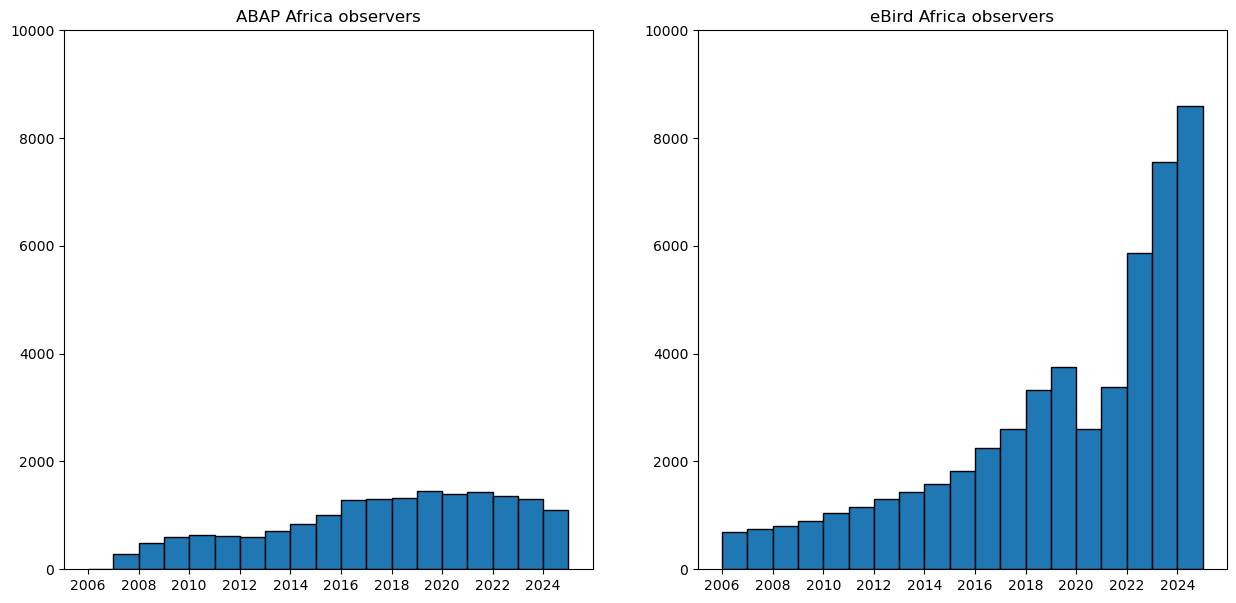

In [10]:
def plot_map(ax, c, title, countries=None, generate2024=False):

    countries_bounds = {
        "South Africa": {"lat": (-35, -22), "lon": (16, 33)},
        "Kenya": {"lat": (-5, 5), "lon": (33, 42)},
        "Nigeria": {"lat": (4, 14), "lon": (3, 15)},
    }

    if countries:
        filters = []
        for country in countries:
            if country in countries_bounds:
                bounds = countries_bounds[country]
                filters.append(
                    (
                        c["lat"].between(*bounds["lat"])
                        & c["lon"].between(*bounds["lon"])
                    )
                )
            else:
                raise ValueError(f"Country '{country}' is not supported.")
        c = c[np.logical_or.reduce(filters)]

    # y = pd.to_datetime(c["startdate"], format="mixed").dt.year
    y = (
        c.copy()
        .assign(year=pd.to_datetime(c["startdate"], format="mixed").dt.year)
        .drop_duplicates(subset=["year", "observer"])["year"]
    )
    if generate2024:
        num_duplicates = int(len(y[y == 2024]) / mean_sp8 - len(y[y == 2024]))
        y = np.concatenate([y, np.full(num_duplicates, 2024)])
    ax.hist(
        y,
        bins=np.arange(2006, np.max(y) + 2, 1),
        edgecolor="black",
    )
    ax.set_ylim(0, 10000)
    ax.set_title(title)
    ax.set_xticks(np.arange(2006, 2025, 2))


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], a_all, "ABAP Africa observers", None, generate2024=False)
plot_map(axs[1], ebd0, "eBird Africa observers", None)

# plt.subplots_adjust(wspace=0)
plt.show()

(array([ 149784.,  188478.,  183621.,  235258.,  291616.,  338597.,
         315303.,  406267.,  468287.,  673208.,  881574., 1077810.,
        1455179., 1656870., 1054024., 1667549., 2851995., 3741508.,
        4150420.]),
 array([2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
        2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., 2023.,
        2024., 2025.]),
 <BarContainer object of 19 artists>)

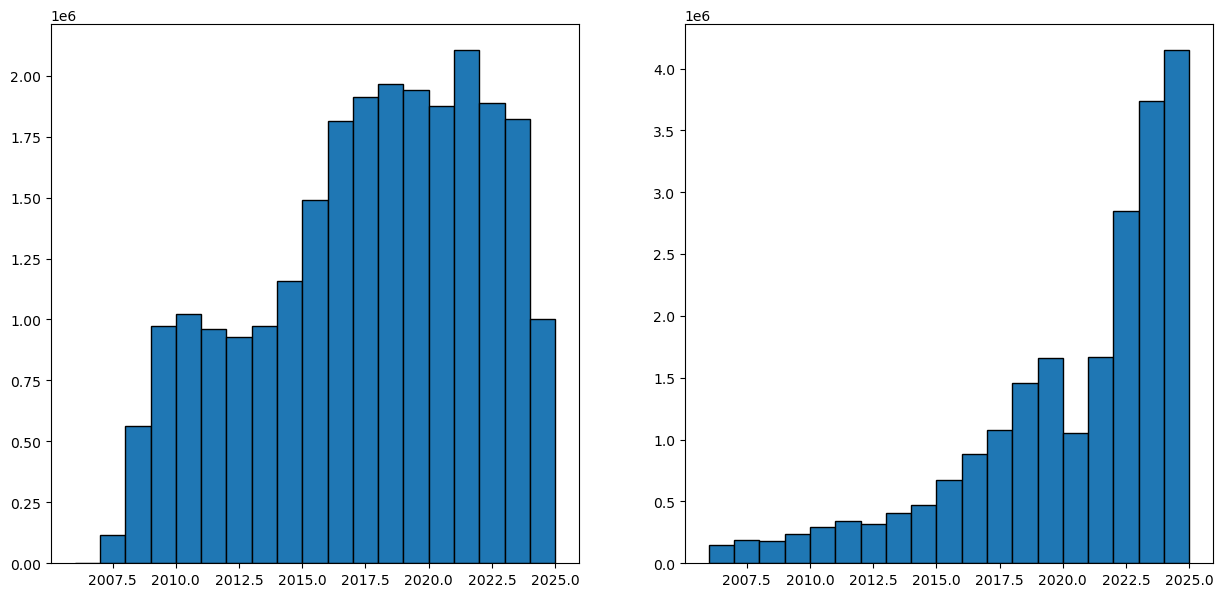

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))


y = a_all.copy().assign(
    year=pd.to_datetime(a_all["startdate"], format="mixed").dt.year
)["year"]

axs[0].hist(
    y,
    bins=np.arange(2006, np.max(y) + 2, 1),
    edgecolor="black",
)

y = ebd0.copy().assign(year=pd.to_datetime(ebd0["startdate"], format="mixed").dt.year)[
    "year"
]

axs[1].hist(
    y,
    bins=np.arange(2006, np.max(y) + 2, 1),
    edgecolor="black",
)

## Read all data


Read full protocol


In [ ]:
a, ac, ar = load_abap(["fp"])

Read latest cards and record table from eBird


In [ ]:
def find_matching_file(directory, month, year, type):
    pattern = rf"ebd_AFR_rel{month}-{year}_.*_{type}\.csv"
    return next(
        (
            os.path.join(root, file)
            for root, _, files in os.walk(directory)
            for file in files
            if re.match(pattern, file)
        ),
        None,
    )


find_matching_file("../export", month, year, "cards")

'../export/ebd_AFR_relDec-2024_20250122_152112_cards.csv'

In [ ]:
ec = pd.read_csv(
    find_matching_file("../export", month, year, "cards"),
    parse_dates=["OBSERVATION DATETIME_min", "OBSERVATION DATETIME_max"],
).rename(
    columns={
        "CARD": "card",
        "OBSERVATION DATE": "startdate",
        "PENTAD": "pentad",
        "OBSERVER ID": "observer",
    }
)
ec["totalhours"] = ec["DURATION MINUTES_sum"] / 60
ec["lat"], ec["lon"] = pentad2latlng(ec["pentad"])
ec.drop(
    ["OBSERVATION DATETIME_min", "OBSERVATION DATETIME_max", "DURATION MINUTES_sum"],
    axis=1,
    inplace=True,
)
ec.drop(["EFFORT DISTANCE KM_sum"], axis=1, inplace=True)
ec = ec[
    (ec["lat"] >= min_lat)
    & (ec["lat"] <= max_lat)
    & (ec["lon"] >= min_lon)
    & (ec["lon"] <= max_lon)
]

ec["SAMPLING EVENT IDENTIFIER_list"] = ec["SAMPLING EVENT IDENTIFIER_list"].apply(
    lambda x: ast.literal_eval(x)
)

In [ ]:
er = pd.read_csv(
    find_matching_file("../export", month, year, "records"),
).rename(columns={"CARD": "card"})

In [ ]:
e = pd.merge(er, ec, how="left")

Add the total number of species


In [ ]:
totalspp = er.groupby("card").size().reset_index(name="totalspp")
ec = ec.merge(totalspp, on="card", how="left")

## eBird user ID


In [ ]:
ec

,card,SAMPLING EVENT IDENTIFIER_list,pentad,observer,startdate,totalhours,lat,lon,totalspp
0,0000_0920_r431479_20220810,"[S116860554, S116861241]",0000_0920,obsr431479,2022-08-10,2.683333,-0.041667,9.375000,19
1,0000_0920_r431479_20240218,"[S162608678, S162609512, S162830782, S16283088...",0000_0920,obsr431479,2024-02-18,3.550000,-0.041667,9.375000,35
2,0000_1105_r347779_20240826,[S196599037],0000_1105,obsr347779,2024-08-26,10.000000,-0.041667,11.125000,4
3,0000_1135_r344577_19970722,[S13388886],0000_1135,obsr344577,1997-07-22,2.000000,-0.041667,11.625000,5
4,0000_1140_r167174_19960708,[S7529043],0000_1140,obsr167174,1996-07-08,3.000000,-0.041667,11.708333,15
...,...,...,...,...,...,...,...,...,...
54566,3715c1010_r2499279_20220514,[S110112495],3715c1010,obsr2499279,2022-05-14,7.000000,37.208333,10.208333,35
54567,3715c1010_r536040_20220516,[S110451064],3715c1010,obsr536040,2022-05-16,6.000000,37.208333,10.208333,21
54568,3715c1010_r536040_20220521,[S110892947],3715c1010,obsr536040,2022-05-21,4.500000,37.208333,10.208333,16
54569,3720c0950_r433404_20240529,"[S178139251, S178166960, S178246101, S178605942]",3720c0950,obsr433404,2024-05-29,5.933333,37.291667,9.875000,14


In [ ]:
eco = (
    ec.groupby("observer")
    .agg(
        {
            "SAMPLING EVENT IDENTIFIER_list": lambda x: sum(
                x, []
            ),  # Flatten the list of lists
            "card": lambda x: list(x),  # Create a list of all card values
        }
    )
    .reset_index()
)

eco["count_checklists"] = eco["SAMPLING EVENT IDENTIFIER_list"].apply(len)
eco["count_card"] = eco["card"].apply(len)

eco

,observer,SAMPLING EVENT IDENTIFIER_list,card,count_checklists,count_card
0,obsr1000055,[S41771115],[1415_3415_r1000055_20180108],1,1
1,obsr1000107,"[S156788500, S160455971, S160682327, S15892339...","[0125_2930_r1000107_20231219, 0155_3040_r10001...",9,3
2,obsr1000284,"[S42670121, S42669995]",[1745_2540_r1000284_20180210],2,1
3,obsr1000294,"[S46715236, S46700522, S44628721, S44628897]","[2145_1355_r1000294_20170821, 2430_1755_r10002...",4,3
4,obsr1000301,[S63501402],[1315b1610_r1000301_20191108],1,1
...,...,...,...,...,...
9734,obsr998672,[S117541018],[2240_1430_r998672_20220718],1,1
9735,obsr998790,"[S78125540, S77660751, S77663368]","[2500_3105_r998790_20201213, 3335_2650_r998790...",3,2
9736,obsr998849,[S41634860],[2605_2755_r998849_20171219],1,1
9737,obsr999150,"[S186142689, S186146292, S186149963, S18615861...","[2855_3145_r999150_20240709, 3040_3015_r999150...",17,3


In [ ]:
print(f"Total number of cards: {sum(eco['count_card']):,}")
print(f"Total number of checklists: {sum(eco['count_checklists']):,}")

Total number of cards: 54,571
Total number of checklists: 154,615


In [ ]:
eco.to_csv(
    "../export/eBird_user_contributions.csv", index=False, encoding="utf-8", sep=";"
)

## Illustration


In [ ]:
print(f"Total card ABAP:    {format(len(ac), ','):>10}")
print(f"Total card eBird:   {format(len(ec), ','):>10}")
print(f"Total record ABAP:  {format(len(ar), ','):>10}")
print(f"Total record eBird: {format(len(er), ','):>10}")

Total card ABAP:       395,130
Total card eBird:       54,571
Total record ABAP:  20,158,671
Total record eBird:  1,889,880


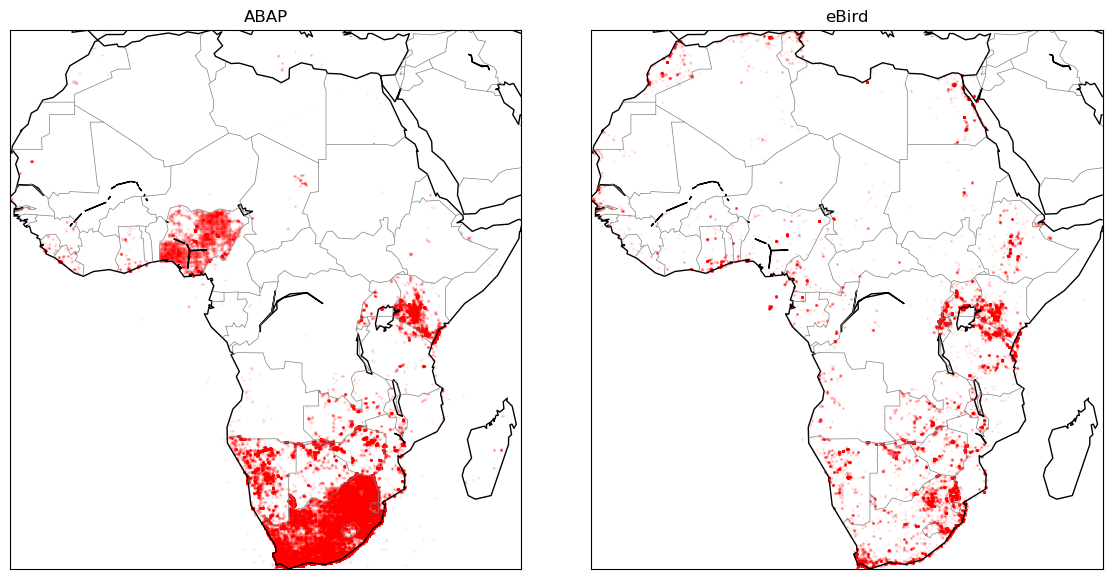

In [ ]:
def plot_map(ax, c, title):
    m = Basemap(
        llcrnrlat=min_lat,
        urcrnrlat=max_lat,
        llcrnrlon=min_lon,
        urcrnrlon=max_lon,
        ax=ax,
    )
    m.drawcoastlines()
    m.drawcountries(color="gray")
    m.scatter(c["lon"], c["lat"], latlon=True, s=1, c="red", marker="o", alpha=0.05)
    ax.set_title(title)


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

plt.subplots_adjust(wspace=0)
plt.show()

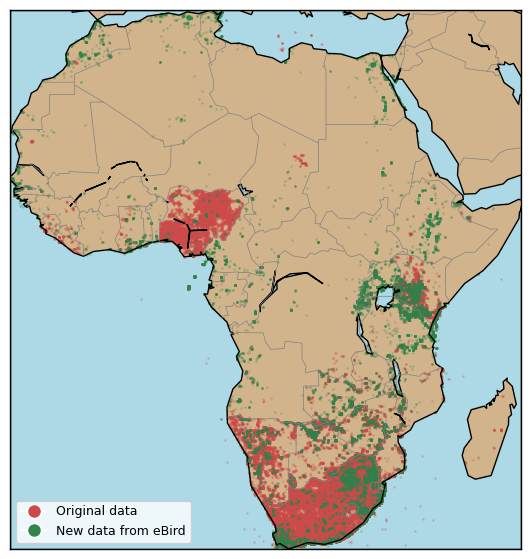

In [ ]:
def plot_combined_map(ax, abap_data, ebird_data):
    m = Basemap(
        llcrnrlat=min_lat,
        urcrnrlat=max_lat,
        llcrnrlon=min_lon,
        urcrnrlon=max_lon,
        ax=ax,
    )

    # Draw background water in blue
    m.drawmapboundary(fill_color="lightblue")

    # Fill the continents with a lighter brown color typical of map backgrounds
    m.fillcontinents(color="#d2b48c", lake_color="lightblue")

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries(color="gray")

    # Plot ABAP data in softer red with normal point size
    m.scatter(
        abap_data["lon"],
        abap_data["lat"],
        latlon=True,
        s=1,
        c="#cc4a4a",
        marker="o",
        alpha=0.2,
        label="Original data",
    )

    # Plot eBird data in the specified green with normal point size
    m.scatter(
        ebird_data["lon"],
        ebird_data["lat"],
        latlon=True,
        s=1,
        c="#33844a",
        marker="o",
        alpha=0.2,
        label="New data from eBird",
    )

    # Create custom legend with larger markers but leave map scatter points unchanged
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="#cc4a4a",
            markersize=10,
            label="Original data",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="#33844a",
            markersize=10,
            label="New data from eBird",
        ),
    ]

    # Display the legend with larger markers
    ax.legend(
        handles=legend_elements, loc="lower left", fontsize=9
    )  # Adjust font size if needed


# Create figure for a single map
fig, ax = plt.subplots(figsize=(10, 7))

# Plot combined map with normal point size and larger legend markers
plot_combined_map(ax, ac, ec)

# Save the figure with high resolution (300 DPI)
plt.savefig("combined_map_high_res.png", dpi=300)

plt.show()

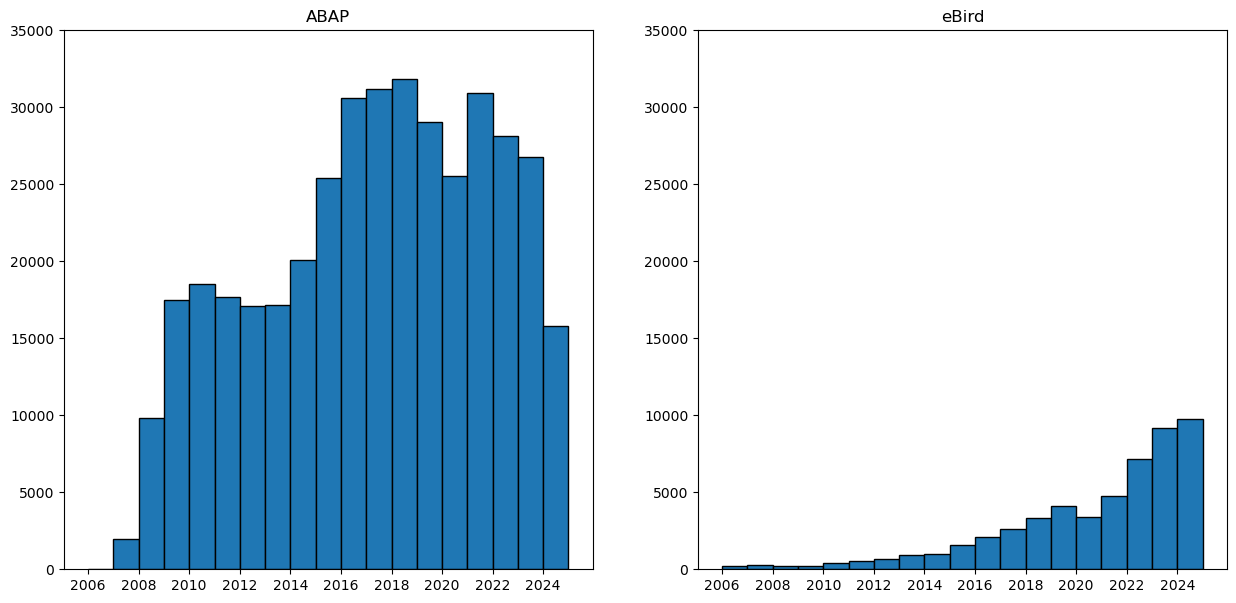

In [ ]:
def plot_map(ax, c, title):
    y = pd.to_datetime(c["startdate"]).dt.year
    ax.hist(
        y,
        bins=np.arange(2006, np.max(y) + 2, 1),
        edgecolor="black",
    )
    ax.set_ylim(0, 35000)
    ax.set_title(title)
    ax.set_xticks(np.arange(2006, 2025, 2))


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

# plt.subplots_adjust(wspace=0)
plt.show()

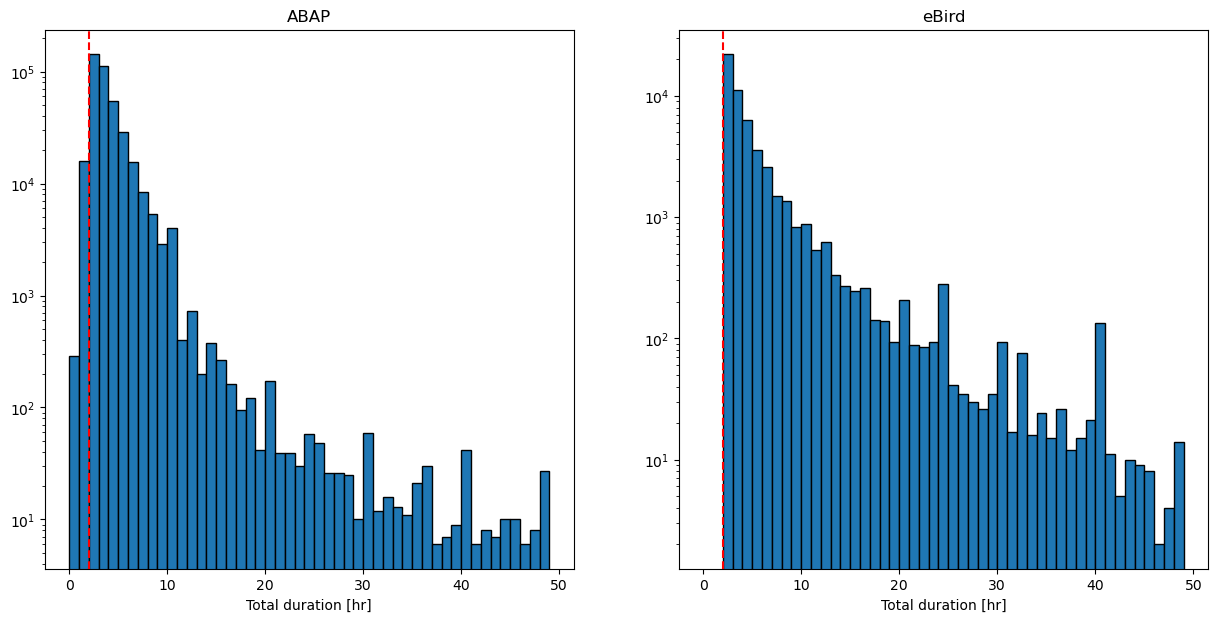

In [ ]:
def plot_map(ax, c, title):
    ax.hist(c["totalhours"], bins=np.arange(0, 50, 1), edgecolor="black", log=True)
    # ax.hist(c["totalhours"], bins=np.arange(0, 25, 1), edgecolor="black")
    ax.set_title(title)
    ax.axvline(x=2, color="red", linestyle="--")
    ax.set_xlabel("Total duration [hr]")
    # ax.set_xticks(np.arange(2006, 2025, 2))


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

# plt.subplots_adjust(wspace=0)
plt.show()

In [ ]:
ac[ac["totalhours"] > 100]

,card,startdate,pentad,observer,totalhours,totalspp,lat,lon,type
395049,2120_2340_013419_20190319,2019-03-19,2120_2340,13419.0,102,62,-21.375000,23.708333,fp
395050,2600_2800_011993_20120131,2012-01-31,2600_2800,11993.0,103,38,-26.041667,28.041667,fp
395051,2600_2800_011993_20120309,2012-03-09,2600_2800,11993.0,103,57,-26.041667,28.041667,fp
395052,2600_2800_011993_20120609,2012-06-09,2600_2800,11993.0,107,49,-26.041667,28.041667,fp
395053,2600_2800_011993_20120520,2012-05-20,2600_2800,11993.0,108,57,-26.041667,28.041667,fp
...,...,...,...,...,...,...,...,...,...
395125,29302955_010730_20121129,2012-11-29,2930_2955,10730.0,240,49,-29.541667,29.958333,fp
395126,29252955_010730_20120917,2012-09-17,2930_2955,10730.0,240,36,-29.541667,29.958333,fp
395127,32302740_010730_20150224,2015-02-24,3230_2740,10730.0,240,44,-32.541667,27.708333,fp
395128,3415_1820_001475_20141220,2014-12-20,3415_1820,1475.0,307,34,-34.291667,18.375000,fp


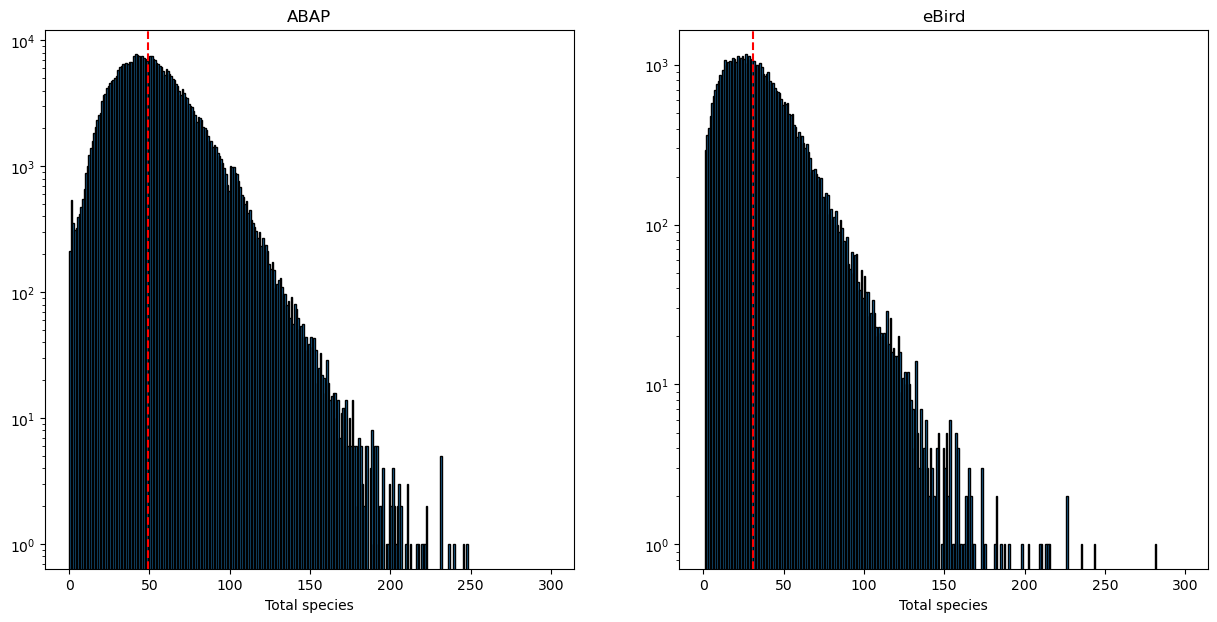

In [ ]:
def plot_map(ax, c, title):
    ax.hist(c["totalspp"], bins=np.arange(0, 300, 1), edgecolor="black", log=True)
    # ax.hist(c["totalspp"], bins=np.arange(0, 200, 1), edgecolor="black")
    ax.axvline(x=np.median(c["totalspp"]), color="red", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Total species")
    # ax.set_xticks(np.arange(2006, 2025, 2))


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

# plt.subplots_adjust(wspace=0)
plt.show()

In [ ]:
ec[ec["totalspp"] < 2]

,card,SAMPLING EVENT IDENTIFIER_list,pentad,observer,startdate,totalhours,lat,lon,totalspp
182,0005_3000_r1194784_20220220,[S103241589],0005_3000,obsr1194784,2022-02-20,5.833333,-0.125000,30.041667,1
274,0005_3000_r534420_20140815,[S19570399],0005_3000,obsr534420,2014-08-15,3.000000,-0.125000,30.041667,1
322,0005_3440_r1715259_20181014,[S69195508],0005_3440,obsr1715259,2018-10-14,2.000000,-0.125000,34.708333,1
861,0005c3225_r1962437_20191011,[S77255481],0005c3225,obsr1962437,2019-10-11,2.000000,0.041667,32.458333,1
1429,0005c3225_r668510_20181011,[S49633559],0005c3225,obsr668510,2018-10-11,2.000000,0.041667,32.458333,1
...,...,...,...,...,...,...,...,...,...
53038,3420_1825_r1101124_20170705,[S47771103],3420_1825,obsr1101124,2017-07-05,10.000000,-34.375000,18.458333,1
53091,3420_1825_r2915149_20191029,[S130249111],3420_1825,obsr2915149,2019-10-29,2.000000,-34.375000,18.458333,1
53141,3420_1825_r88127_20130104,[S14210192],3420_1825,obsr88127,2013-01-04,2.000000,-34.375000,18.458333,1
53984,3520b0535_r195106_20221012,[S120945072],3520b0535,obsr195106,2022-10-12,2.000000,35.291667,-5.541667,1


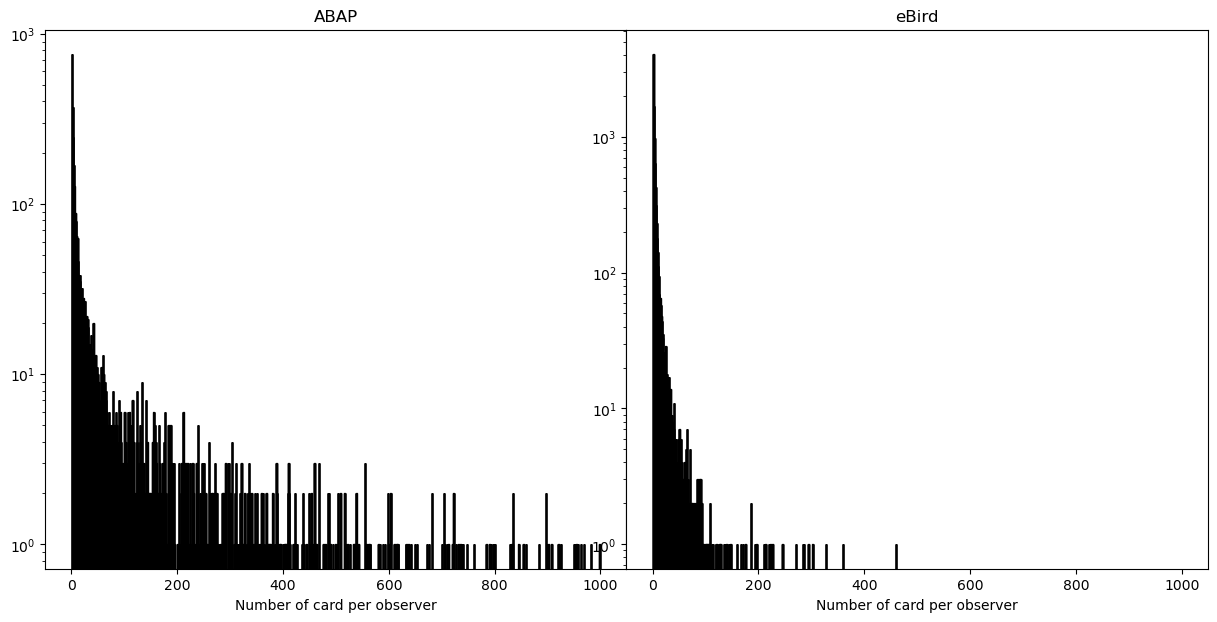

In [ ]:
def plot_map(ax, c, title):
    ax.hist(
        c.groupby("observer").count(),
        bins=np.arange(0, 1000, 1),
        edgecolor="black",
        log=True,
    )
    ax.set_title(title)
    ax.set_xlabel("Number of card per observer")


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

plt.subplots_adjust(wspace=0)
plt.show()

## Per country


In [ ]:
ecp = (
    ec.groupby("pentad")
    .agg(lat=("lat", "first"), lon=("lon", "first"), nb_card=("pentad", "size"))
    .reset_index()
)

acp = (
    ac.groupby("pentad")
    .agg(lat=("lat", "first"), lon=("lon", "first"), nb_card=("pentad", "size"))
    .reset_index()
)

In [ ]:
afr = gpd.read_file("../data/Africa_Boundaries-shp/Africa_Boundaries.shp").to_crs(
    epsg=4326
)
afr = afr.rename(columns={"NAME_0": "country"})

ecgdf = gpd.GeoDataFrame(
    ecp, geometry=gpd.points_from_xy(ecp["lon"], ecp["lat"]), crs="EPSG:4326"
)
ecgdf = gpd.sjoin(ecgdf, afr)

acgdf = gpd.GeoDataFrame(
    acp, geometry=gpd.points_from_xy(acp["lon"], acp["lat"]), crs="EPSG:4326"
)
acgdf = gpd.sjoin(acgdf, afr)

In [ ]:
country = pd.merge(
    ecgdf.groupby("country")
    .agg(nb_card_ebird=("nb_card", "sum"), pentad_ebird=("country", "size"))
    .reset_index(),
    acgdf.groupby("country")
    .agg(nb_card_abap=("nb_card", "sum"), pentad_abap=("country", "size"))
    .reset_index(),
)

In [ ]:
country.to_csv(
    "../export/country_list_ebird_abap.csv", index=False, encoding="utf-8", sep=";"
)

In [ ]:
afr2 = pd.merge(afr, country, how="left")
afr2["nb_card_ebird"] = afr2["nb_card_ebird"].fillna(0)
afr2["nb_card_abap"] = afr2["nb_card_abap"].fillna(0)
afr2["ratio"] = afr2["nb_card_ebird"] / afr2["nb_card_abap"]
afr2["ratio"] = afr2["ratio"].fillna(0)

In [ ]:
afr2

,OBJECTID,ISO,country,Continent,REgion,geometry,nb_card_ebird,pentad_ebird,nb_card_abap,pentad_abap,ratio
0,1,AGO,Angola,Africa,None,"MULTIPOLYGON (((11.70236 -16.50764, 11.70236 -...",331.0,113.0,343.0,91.0,0.965015
1,2,ATF,French Southern Territories,Africa,None,"MULTIPOLYGON (((68.86333 -50.01889, 68.86166 -...",0.0,NaN,0.0,NaN,0.000000
2,3,BDI,Burundi,Africa,Eastern_Africa,"POLYGON ((30.41152 -2.31061, 30.41243 -2.3118,...",0.0,NaN,0.0,NaN,0.000000
3,4,BEN,Benin,Africa,None,"MULTIPOLYGON (((1.87042 6.28819, 1.87042 6.287...",41.0,25.0,15.0,12.0,2.733333
4,5,BFA,Burkina Faso,Africa,None,"POLYGON ((-0.45567 15.08082, -0.44206 15.06812...",22.0,10.0,1.0,1.0,22.000000
5,6,BWA,Botswana,Africa,None,"POLYGON ((25.21502 -17.79051, 25.24286 -17.792...",1105.0,242.0,4272.0,962.0,0.258661
6,7,CAF,Central African Republic,Africa,None,"POLYGON ((22.54251 10.99812, 22.55266 10.99373...",60.0,13.0,6.0,5.0,10.000000
7,8,CIV,Côte d'Ivoire,Africa,None,"MULTIPOLYGON (((-6.6693 4.72958, -6.6693 4.729...",66.0,26.0,2.0,1.0,33.000000
8,9,CMR,Cameroon,Africa,None,"MULTIPOLYGON (((9.63403 3.56208, 9.63403 3.561...",341.0,99.0,20.0,16.0,17.050000
9,10,COD,Democratic Republic of the Congo,Africa,None,"MULTIPOLYGON (((12.45764 -6.02181, 12.45764 -6...",464.0,88.0,65.0,31.0,7.138462


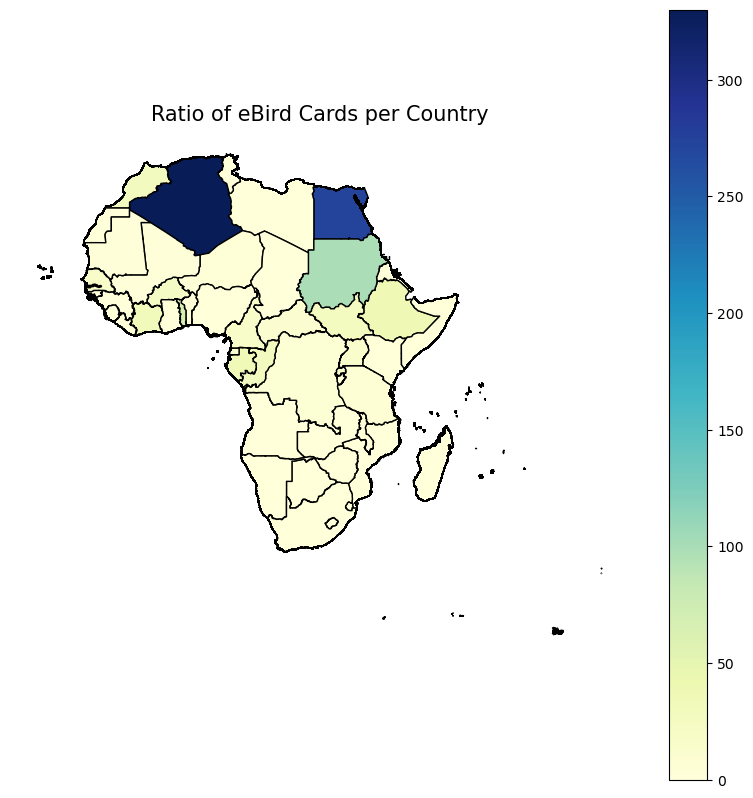

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming afr2 is a GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the choropleth map using the 'ratio' column with the 'YlGnBu' colormap
afr2.plot(column="ratio", ax=ax, legend=True, cmap="YlGnBu", edgecolor="black")

# Add a title
ax.set_title("Ratio of eBird Cards per Country", fontsize=15)

# Remove axis for a cleaner map
ax.set_axis_off()

# Display the plot
plt.show()

# Save the plot as a static image file
fig.savefig("africa_ratio_map_with_borders.png", bbox_inches="tight")

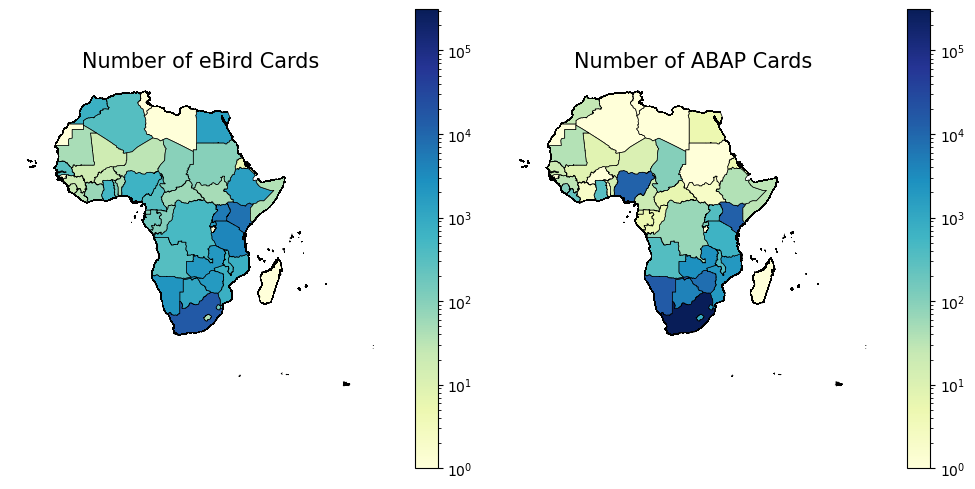

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming afr2 is a GeoDataFrame

# Replace zeros or negative values with a small positive value (e.g., 1) to apply LogNorm
afr2["nb_card_ebird"] = afr2["nb_card_ebird"].clip(lower=1)
afr2["nb_card_abap"] = afr2["nb_card_abap"].clip(lower=1)

# Create a log scale normalization for both plots to share the same color scale
norm = mcolors.LogNorm(
    vmin=min(afr2[["nb_card_ebird", "nb_card_abap"]].min()),
    vmax=max(afr2[["nb_card_ebird", "nb_card_abap"]].max()),
)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first map for 'nb_card_ebird' with log scale normalization
afr2.plot(
    column="nb_card_ebird",
    ax=ax1,
    legend=True,
    cmap="YlGnBu",
    edgecolor="black",
    linewidth=0.5,
    norm=norm,
)
ax1.set_title("Number of eBird Cards", fontsize=15)
ax1.set_axis_off()

# Plot the second map for 'nb_card_abap' with the same log scale normalization
afr2.plot(
    column="nb_card_abap",
    ax=ax2,
    legend=True,
    cmap="YlGnBu",
    edgecolor="black",
    linewidth=0.5,
    norm=norm,
)
ax2.set_title("Number of ABAP Cards", fontsize=15)
ax2.set_axis_off()

# Display the plot
plt.tight_layout()
plt.show()

## Species specific


Get list of all pentand and associated country


In [ ]:
cgdf = pd.concat([ecgdf, acgdf], axis=0, ignore_index=True)
cgdf = cgdf[["pentad", "lat", "lon", "country"]].drop_duplicates()

In [ ]:
def pivot_filter(r, c):
    # Filter records with more than 20 species
    r = r[r["card"].isin(c["card"][c["totalspp"] > 30])]

    rt = pd.pivot_table(
        r[["ADU", "card"]], index="card", columns="ADU", aggfunc="size", fill_value=0
    )
    rt = rt.merge(c[["card", "pentad"]], on="card", how="left")
    rt = rt.merge(cgdf, on="pentad", how="left")
    return rt


# Create the record matrix for eBird and ABAP

ert = pivot_filter(er, ec)
art = pivot_filter(ar, ac)

Filter for any country


In [ ]:
def compute_freq(rt, ctr=["Kenya", "Nigeria", "South Africa"]):
    # Filter for countries
    rtc = rt[rt["country"].isin(ctr)]

    # Compute frequency for each species
    species_columns = rtc.columns.difference(
        ["card", "pentad", "lat", "lon", "country"]
    )

    # Compute the frequency (fraction of cards with value > 0) for each species
    freq = rtc[species_columns].apply(lambda x: (x > 0).mean(), axis=0)

    return freq.reset_index().rename(columns={"index": "ADU"})


ctr = ["South Africa"]

freq_ebird = compute_freq(ert, ctr)
freq_ebird.rename(columns={freq_ebird.columns[1]: "eBird"}, inplace=True)
freq_abap = compute_freq(art, ctr)
freq_abap.rename(columns={freq_abap.columns[1]: "ABAP"}, inplace=True)

freq_comp = pd.merge(freq_ebird, freq_abap, on="ADU", how="outer").fillna(0)

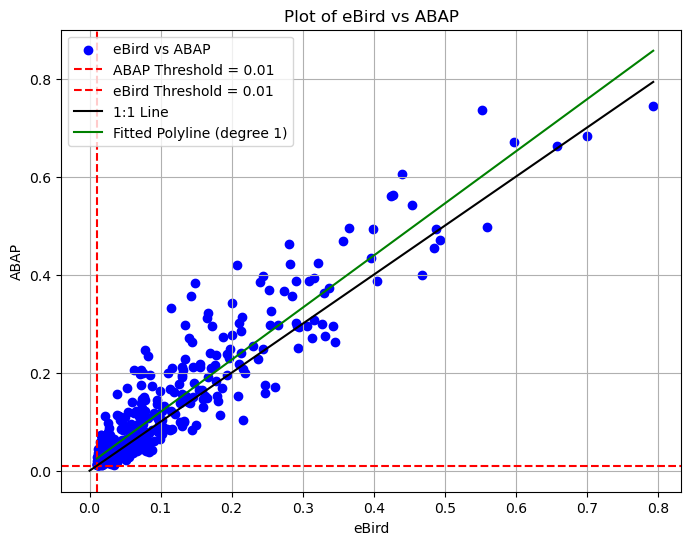

In [ ]:
threshold = 0.01

# Filter rows where either eBird or ABAP is below the threshold
freq_comp_c = freq_comp[
    (freq_comp["eBird"] > threshold) & (freq_comp["ABAP"] > threshold)
]

# Fitting a polynomial (degree 1 for linear fit)
degree = 1
coeffs = np.polyfit(freq_comp_c["eBird"], freq_comp_c["ABAP"], degree)  # Linear fit
eBird_smooth = np.linspace(freq_comp_c["eBird"].min(), freq_comp_c["eBird"].max(), 100)
ABAP_smooth = np.polyval(coeffs, eBird_smooth)


# Plotting eBird vs ABAP
plt.figure(figsize=(8, 6))
plt.scatter(
    freq_comp_c["eBird"], freq_comp_c["ABAP"], color="blue", label="eBird vs ABAP"
)
plt.xlabel("eBird")
plt.ylabel("ABAP")
plt.title("Plot of eBird vs ABAP")

# Adding threshold lines
plt.axhline(
    y=threshold, color="red", linestyle="--", label=f"ABAP Threshold = {threshold}"
)
plt.axvline(
    x=threshold, color="red", linestyle="--", label=f"eBird Threshold = {threshold}"
)

# Adding 1:1 line
plt.plot(
    [0, max(freq_comp_c["eBird"].max(), freq_comp_c["ABAP"].max())],
    [0, max(freq_comp_c["eBird"].max(), freq_comp_c["ABAP"].max())],
    color="black",
    linestyle="-",
    label="1:1 Line",
)

# Adding the fitted polynomial line
plt.plot(
    eBird_smooth,
    ABAP_smooth,
    color="green",
    linestyle="-",
    label=f"Fitted Polyline (degree {degree})",
)

plt.legend()
plt.grid(True)
plt.show()